# Segmentation

이미지 분할, 픽셀 단위 레이블 예측  

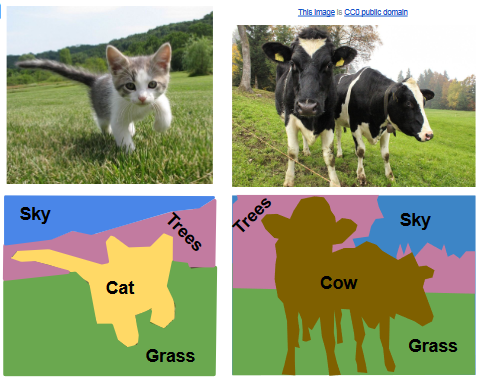  
Source [Stanford cs231n](http://cs231n.stanford.edu/)  
이런식으로 보인다

기초적인 이미지 분류의 경우는 전체 이미지가 나타내는게 무엇인지 판단하는것에서 그쳤다면(위 사진의 경우 왼쪽은 고양이, 오른쪽은 소 라고만 분류), Segmentation은 이미지의 각 픽셀마다 레이블을 예측해 이미지에서 어떤 부분이 어떤 클래스인지 판단한다.  
위 이미지로 보면 고양이뿐만 아니라 풀, 하늘, 나무들의 정보도 알려준다. 이를 위해서 출력단에는 클래스의 개수만큼 채널을 만들어주면 된다. 각 채널에 클래스가 있는지 여부를 확률로 알려주고 하나의 이미지로 합칠 대 전체 채널에서 확률이 가장 높은 클래스를 보여주게 된다.  
Instance Segmentation의 경우에는 같은 클래스라도 개별적인 객체로 인식해 다르다고 구별해준다. 

그럼 이런 과정을 위해 어떻게 모델을 만들어야 하는가?  
슬라이딩 윈도우를 사용해 부분 이미지마다 클래스를 예측하는 경우를 생각해 볼 수 있다. 하지만 겹치는 부분에 연산을 중복해야되서 자원이 굉장히 많이 들어 사용하지 않는다.

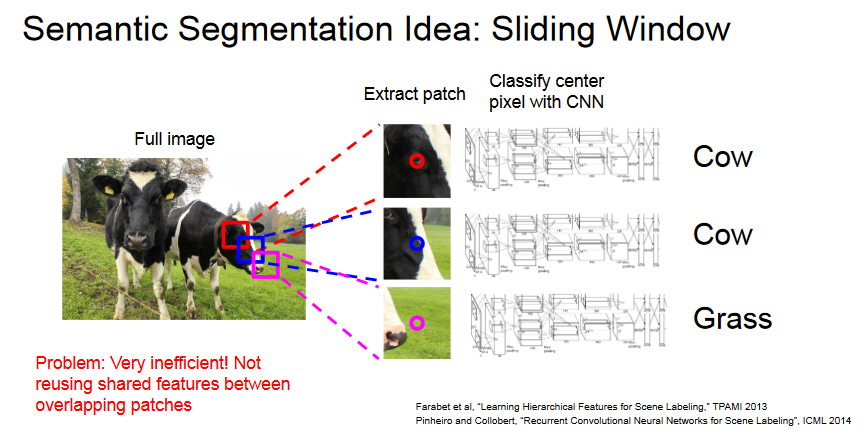

다른 방법으로는 원본 이미지의 픽셀 위치정보를 기억해야하기 위해 Dense 레이어를 쓰지 않고 Conv2D 레이어를 연결시키는 방법도 있다. 하지만 전체 이미지 크기만큼 필터 크기를 지정한다면 학습 해야할 파라미터가 많아져서 채널을 늘리고 크기를 줄였다가 다시 Upsampling을 통해 차원을 줄이고 이미지 크기를 늘리는 방식을 사용한다. 물론 예측해야할 클래스가 많아지면 연산량이 많아진다.  
아래 처럼 학습 하는게 기본적인 FCN(Fully Convolutional Network) 모델이다.  

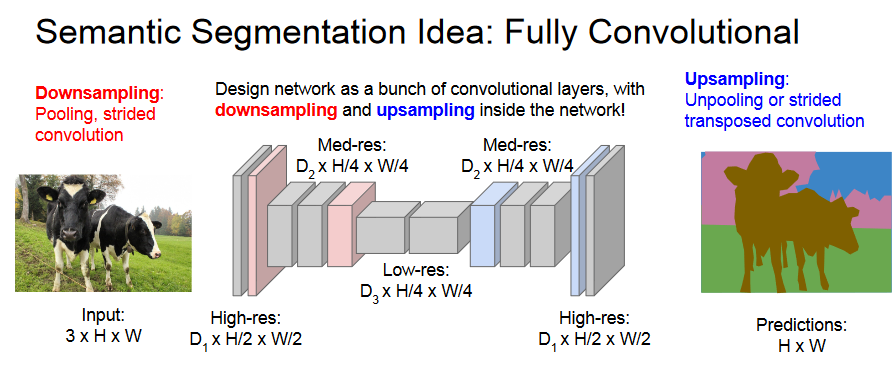

위와 같은 방식을 사용하기 위한 Upsamlping 방법에는 Unpooling 방법과 Transpose Convolution이 있다. Max Unpooling은 Maxpooling의 반대로 작동한다. Maxpooling(기본값일 때)이 2x2에서 가장 큰 값 하나를 뽑아내서 한 픽셀에 값을 부여하는 것이라면 Max Unpooling은 한 값이 2x2로 들어가는 것이다. 4 픽셀 모두에 같은 값을 부여할 수도 있고 4 픽셀 중 1 픽셀에만 값을 주고 나머지는 0으로 둘 수도 있다. 하지만 이 경우 이 최대값이 어디서 온지 알 수 없기 때문에 Maxpooling 할 때 값을 가져온 위치를 학습해 그 위치에 다시 넣어주는 방법을 사용하는게 낫다. 하지만 Maxunpooling은 학습을 하는게 아니기때문에 다른 방법을 사용한다.

# Transpose Convolution  
Conv2D와 반대(?)로 작동하는 `Transpose Convolution`을 사용해서 이미지의 크기를 늘려준다. 

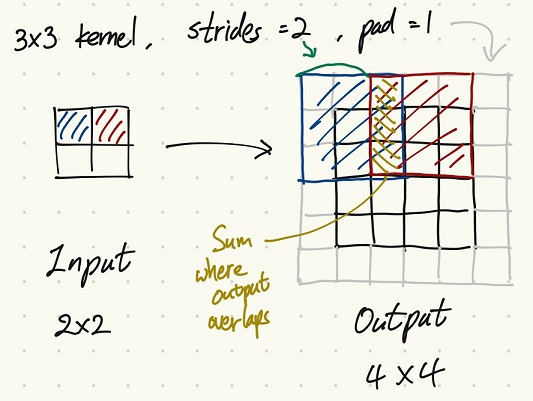

Keras에서는 이를 Conv2DTranspose로 제공하고 있다.

```python
tf.keras.layers.Conv2DTranspose(filters, kernel_size, strides=(1, 1), padding='valid', ...)
```

여기서 값들은 Conv2D와 동일한 의미이다. 차이점은 Conv2D와 반대라는 것. 입력의 한칸이 kernel_size만큼 출력부분으로 맵핑되고, 출력 부분의 커널이 strides 만큼 움직인다. 패딩도 출력부분에 추가된다.  
이때 커널 사이즈를 (3, 3), strides를 2, padding을 'same' (pad=1)로 둔다면 Conv2D에서 출력 크기가 입력 크기의 절반이 된다. 마찬가지로 Conv2DTranspose에서는 출력의 크기가 입력의 두 배가 된다.
$$
N_{out} = [\frac{N_{in} - k + 2*p}{s}]
$$

를 통해 쉽게 알 수 있다. (k는 커널 사이즈, p는 패딩, s는 스트라이드다) 커널 사이즈가 4일때도 만족을 하지만 짝수 크기의 커널 사이즈는 사용하지 않는다.([왜?](https://medium.com/geekculture/why-is-odd-sized-kernel-preferred-over-even-sized-kernel-a767e47b1d77))

# U-Net

위 방법들을 사용한 모델 중 하나인 U-Net을 보자

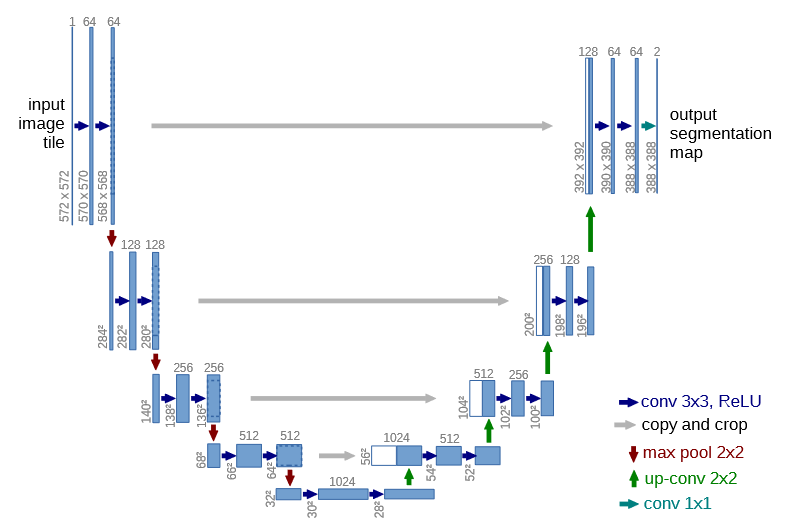

[paper](https://arxiv.org/pdf/1505.04597.pdf)


## Architecture

U-Net 모델을 보면 U자 형태로 되어있다. 가운데를 기준으로 왼쪽은 Contracting path, 오른쪽은 Expansive path이다. Contracting path는 패딩이 없는 3x3 Conv2D와 ReLU를 두 번 통과하고 2x2 Maxpooling으로 다운 샘플링 된다. 패딩을 해주지 않기 때문에 이미지 크기가 조금 줄어들고, Maxpooling으로 크기가 절반이 된다. 그리고 Maxpooling을 통과하기 전에 조금 잘라낸 Conv2D 결과를 Expansive path로 연결시켜준다. 이 연결은 Upsampling 과정에서 Downsampling 할때 사용했던 정보를 모아 더 명확한 출력을 낼 수 있도록 해준다.

Expansive path에서는 Transpose Convolution을 이용한 Upsampling이 진행된다. 이 2x2 convolution을 통해 feature map의 크기(이미지? 크기)가 두배가 되고 채널은 절반이 된다. 채널이 절반이 되었을 때 Contracting path에서 feature map의 일부를 잘라낸 부분이 붙게 된다. 그래서 가장 아래에서 두 번째를 보면 채널이 512로 줄어야하는데 1024개의 채널을 가진다. feature map을 잘라주는 이유는 Expansive path에 연결해 줄 때 크기를 맞춰주기 위함이다. 이 합쳐진 feature map을 두개의 3x3 Conv2D 층(활성화 함수는 ReLU)에 통과시켜준다. 이 과정을 4번 반복하고 마지막에는 1x1 Conv2D를 써서 64개의 채널을 목표로 하는 클래스의 수로 맞춰준다.

출력하는 타일의 크기를 고려해서 입력 이미지가 2x2 Maxpooling이 가능하도록 맞춰주는것이 좋다.

## Strategy

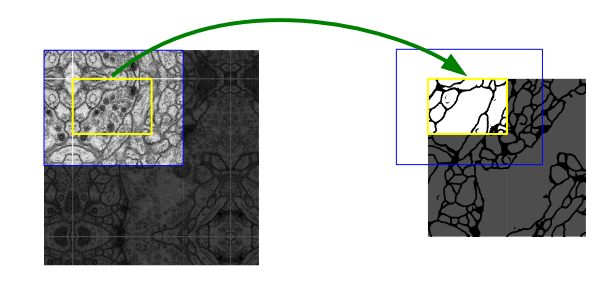

Conv2D를 진행할 때 패딩을 해주지 않기 때문에 입력으로 넣어주는 이미지와 예측한 결과의 크기가 다르게 나타난다. 그래서 노란색 부분을 예측하기 위해서 파란색 부분까지 입력을 넣어주며, 비어있는 부분은 노란색 영역을 뒤집어서 복사해 사용한다(Mirroring extrapolation)

이 모델은 biomedical 분야에 맞춰서 만들어졌다. 특히 이 문제에서는 사용 가능한 훈련 데이터 수가 매우 적어 elastic deformation을 적용해 데이터를 augmentation 해주었다. Biomedical segmentation 에서는 이 elastic deformation이 실제 조직의 변화를 효율적으로 시뮬레이션 할 수 있기 때문에 자주 사용한다. 또 이동과 회전, 변형, 픽셀의 밝기등에 대해서도 robust한 모델을 만들어주어야해서 이 random elastic deformation을 사용해 증강시켰다.

다른 문제는 같은 클래스의 객체가 붙어있는 경우 이를 분리해주는 것이다. 이를 해결하기 위해 손실에 가중치를 주는 방식을 사용했는데, 붙어있는 셀을 나누는 공간에 손실함수의 가중치를 크게 주도록 해주었다.

논문에서는 모델의 깊이가 깊어지고 길이 많아질 수록 가중치의 초기값이 더욱 중요해진다고 하면서 초기값을 표준편차가 $\sqrt{2/N}$인 가우시안 분포로 부여했다. $N$은 하나의 뉴런에 있는 노드의 수이다. 예를 들어 커널의 크기가 3x3이고 이전 층의 채널이 64개라면 $N=9*64=576$이다.

---

# 모델 구현

## Import

In [7]:
import os
import gc
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras import layers
import keras.backend as K

import warnings
warnings.filterwarnings('ignore')

Kaggle, Severstal: Steel Defect Detection Competition의 데이터를 가져왔다.  
참고: https://www.kaggle.com/code/cdeotte/keras-unet-with-eda


In [8]:
path = '/kaggle/input/severstal-steel-defect-detection/'
train = pd.read_csv(path + 'train.csv')
images = pd.DataFrame({'ImageId': os.listdir(path+'train_images')})

In [9]:
# train.csv에 없는 이미지가 있다. defect가 없는 경우
train2 = pd.merge(train, images, how='right').sort_values('ImageId')
train2 = train2.reset_index(drop=True)

# 클래스별로 rle를 보게 wide 형태로 바꿔준다
train2 = train2.pivot(index=['ImageId'], columns=['ClassId'], values=['EncodedPixels'])
train2 = train2.reset_index()

train2 = train2.groupby('ImageId').sum().reset_index()
train2.columns = ['ImageId', ' ', 'e1', 'e2', 'e3', 'e4']
train2 = train2.drop(' ', axis=1)

train2['count'] = train2.apply(lambda x: 4-x.value_counts()[0], axis=1)
train2.head()

,ImageId,e1,e2,e3,e4,count
0,0002cc93b.jpg,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0,0,0,1
1,00031f466.jpg,0,0,0,0,0
2,000418bfc.jpg,0,0,0,0,0
3,000789191.jpg,0,0,0,0,0
4,0007a71bf.jpg,0,0,18661 28 18863 82 19091 110 19347 110 19603 11...,0,1


데이터는 ImageId, ClassId, EncodedPixels로 이루어져있다.
ClassId에는 [1, 2, 3, 4] 4가지로 defect가 분류되어있다.
EncodedPixels는 RLE(Run-length encoding)으로 되어있다. 이 코드는 두 부분으로 나눌 수 있는데, 앞에 오는 숫자가 시작 위치, 뒤에 오는 숫자가 연속된 픽셀의 수 이다. 29102 12 라면 29102 위치에서 12픽셀이 연속으로 마킹되었다는 뜻이다.

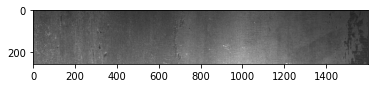

In [10]:
im = Image.open(path+'train_images/0002cc93b.jpg')
plt.imshow(im);

이미지 사이즈가 256x1600인데 메모리 제한이 있어 128x800으로 줄여서 사용한다.

## Utility Function
- resize image (256x1600 -> 128x800, memory limit)
- convert rle to mask
- convert mask to contour
- enlarge mask
- metric, dice coefficient

$$
coef = \frac{2*|X \cap Y|}{|X| + |Y|}
$$

In [11]:
def rle2mask(rle):
    if rle==0:
        return np.zeros((128, 800), dtype=np.uint8)
    
    height = 256
    width = 1600
    # rle 픽셀의 위치는 width*height의 1D, 1부터 시작이라 -1 해준다.
    mask = np.zeros(width*height, dtype=np.uint8)
    
    starts_lengths = np.asarray([int(x) for x in rle.split()])
    starts = starts_lengths[0::2]-1 # 시작 위치
    lengths = starts_lengths[1::2] # 길이
    for idx, start in enumerate(starts): # 시작 위치부터 길이 동안 1 부여
        mask[int(start): int(start+lengths[idx])] = 1
        
    # order='F' 인 경우 column부터 채운다. 사이즈를 줄이기 위해 2칸씩 건너뜀
    return mask.reshape((height, width), order='F')[::2, ::2]

def mask2contour(mask, width=3):
    w = mask.shape[1]
    h = mask.shape[0]
    
    # mask 된 부분을 width 만큼 밀어서 xor이 참인 부분만 가져온다 -> 경계선만 가져와진다.
    mask2 = np.concatenate([mask[:, width:], np.zeros((h, width))], axis=1)
    mask2 = np.logical_xor(mask, mask2)
    mask3 = np.concatenate([mask[width:, :], np.zeros((width, w))], axis=0)
    mask3 = np.logical_xor(mask, mask3)
    
    return np.logical_or(mask2, mask3)

def mask_padding(mask, pad=2):
    # 마스킹이 더 넓은 범위를 포함할 수 있도록 패딩을 추가한다. 기본값은 4방으로 한 픽셀씩
    w = mask.shape[1]
    h = mask.shape[0]
    
    # 위
    for i in range(1, pad, 2):
        temp = np.concatenate([mask[i:, :], np.zeros((i, w))], axis=0)
        mask = np.logical_or(mask, temp)
    # 아래
    for i in range(1, pad, 2):
        temp = np.concatenate([np.zeros((i, w)), mask[:-i, :]], axis=0)
        mask = np.logical_or(mask, temp)
    # 왼쪽
    for i in range(1, pad, 2):
        temp = np.concatenate([mask[:, i:], np.zeros((h, i))], axis=1)
        mask = np.logical_or(mask, temp)
    # 오른쪽
    for i in range(1, pad, 2):
        temp = np.concatenate([np.zeros((h, i)), mask[:, :-i]], axis=1)
        mask = np.logical_or(mask, temp)
    
    return mask

# 평가함수는 Dice Coefficient를 사용한다.
def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f* y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## DataLoader

```python
# https://minimin2.tistory.com/100
# 커스텀 데이터 로더 기본 구조
class DataLoader(tf.keras.utils.Sequence):
    # 필요한 데이터 받아오기
    def __init__(self, x, y, batch_size=16, shuffle=False):
        super().__init__()
        self.x = x
        self.y = y
        self.batch_size = batch_size
        self.shuffle = shuffle
        
    # 데이터 로더의 길이, 올린(전체 데이터 길이 / 배치 사이즈)
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    # 인덱스에 따라 데이터 반환
    def __getitem__(self, idx):
        # 배치 사이즈만큼 데이터를 가져옴 (sampler)
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]
        
        batch_x = [self.x[i] for i in indices]
        batch_y = [self.y[i] for i in indices]
#         batch_x = []
#         batch_y = []
#         for i in indices:
#             batch_x.append(self.x[i])
#             batch_y.append(self.y[i])

        return np.array(batch_x), np.array(batch_y)
    
    # epoch가 끝날 때마다 실행, 여기서는 에포크마다 데이터가 랜덤으로 들어가게 섞어준다
    def on_epoch_end(self):
        self.indices = np.arange(len(self.x))
        if self.shuffle == True:
            np.random.shuffle(self.indices)
```

In [12]:
# 이미지 로드를 위한 데이터로더
class DataLoader(tf.keras.utils.Sequence):
    def __init__(self, df, batch_size=16, subset='train', shuffle=False):
        super().__init__()
        self.df = df
        self.shuffle = shuffle
        self.subset = subset
        self.batch_size = batch_size
        
        if self.subset == 'train':
            self.data_path = path + 'train_images/'
        elif self.subset == 'test':
            self.data_path = path + 'test_images/'
        self.on_epoch_end()
       
    def __len__(self):
        return math.ceil(len(self.df)/self.batch_size)
    
    def __getitem__(self, idx):
        X = np.zeros((self.batch_size, 128, 800, 3), dtype=np.float32)
        Y = np.zeros((self.batch_size, 128, 800, 4), dtype=np.int8)
        indices = self.indices[idx*self.batch_size: (idx+1)*self.batch_size]
        
        for i, f in enumerate(self.df['ImageId'].iloc[indices]):
            X[i] = Image.open(self.data_path + f).resize((800, 128))
            if self.subset == 'train':
                for j in range(4):
                    Y[i, ..., j] = rle2mask(self.df['e'+str(j+1)].iloc[indices[i]])
                
        if self.subset == 'train':
            return X, Y
        else:
            return X
        
    def on_epoch_end(self):
        self.indices = np.arange(len(self.df))
        if self.shuffle == True:
            np.random.shuffle(self.indices)

defect1: red, defect2: green, defect3: yellow, defect4: purple


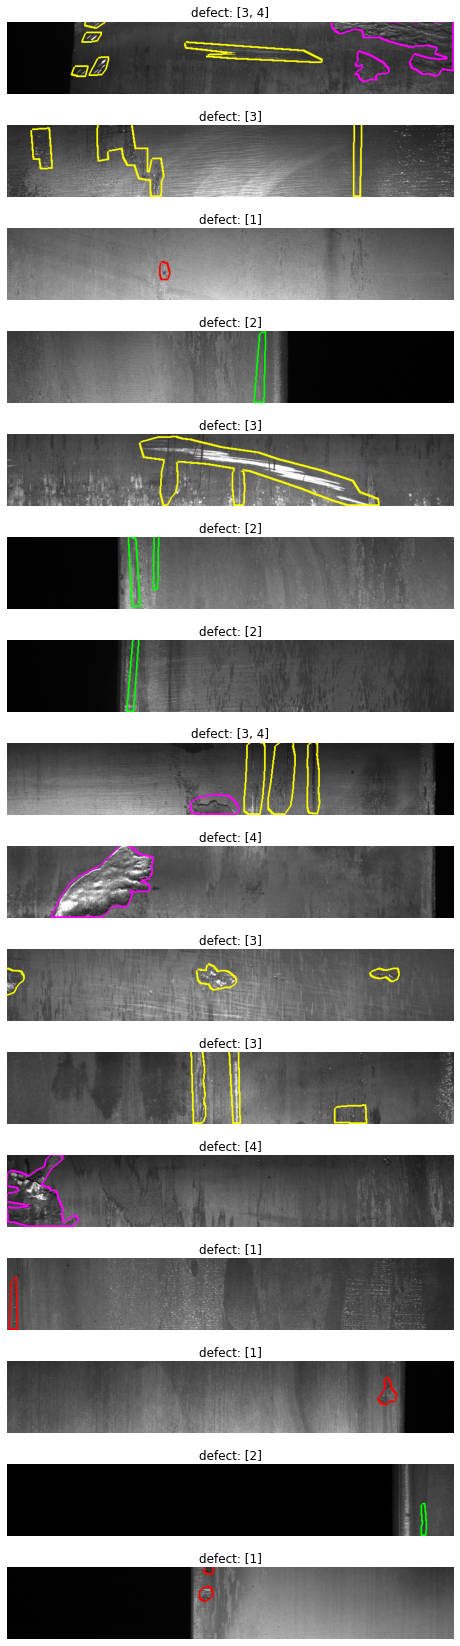

In [13]:
# 결함이 있는 이미지만 가져오기
defects = list(train2[train2['e1']!=0].sample(4).index)
defects += list(train2[train2['e2']!=0].sample(4).index)
defects += list(train2[train2['e3']!=0].sample(4).index)
defects += list(train2[train2['e4']!=0].sample(4).index)

# 데이터 로더 호출
train_batches = DataLoader(train2[train2.index.isin(defects)], shuffle=True)
print('defect1: red, defect2: green, defect3: yellow, defect4: purple')

plt.figure(figsize=(8, 30))
for batch in train_batches:
    for i in range(16):
        plt.subplot(16, 1, i+1)
        img = batch[0][i]/255
        defect = []
        
        for j in range(4):
            msk = batch[1][i, ..., j]
            msk = mask_padding(msk)
            msk = mask2contour(msk)
            if np.sum(msk) != 0:
                defect.append(j+1)
            if j == 0:
                img[msk==1] = 1, 0, 0
            elif j == 1:
                img[msk==1] = 0, 1, 0
            elif j == 2:
                img[msk==1] = 1, 1, 0
            elif j == 3:
                img[msk==1] = 1, 0, 1
                
        plt.title(f'defect: {defect}')
        plt.axis('off')
        plt.imshow(img)
    plt.show()

### Model

In [14]:
def get_model(input_shape, init_node, classify):
    out_dim = init_node
    
    input_ = tf.keras.Input(shape=input_shape)
    
    # Contracting Path
    conv1 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(input_)
    conv1_out = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv1)
    conv2 = layers.MaxPool2D()(conv1_out)
    
    out_dim *= 2
    conv2 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv2)
    conv2_out = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv2)
    conv3 = layers.MaxPool2D()(conv2_out)
    
    out_dim *= 2
    conv3 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv3)
    conv3_out = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv3)
    conv4 = layers.MaxPool2D()(conv3_out)
    
    out_dim *= 2
    conv4 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv4)
    conv4_out = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv4)
    conv5 = layers.MaxPool2D()(conv4_out)
    
    # Mid
    out_dim *= 2
    conv_mid = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv5)
    conv_mid = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(conv_mid)
    
    # Expansive Path
    out_dim /= 2
    t_conv1 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(conv_mid)
    t_conv1 = layers.Concatenate()([conv4_out, t_conv1])
    t_conv1 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv1)
    t_conv1 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv1)
    
    out_dim /= 2
    t_conv2 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(t_conv1)
    t_conv2 = layers.Concatenate()([conv3_out, t_conv2])
    t_conv2 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv2)
    t_conv2 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv2)
    
    out_dim /= 2
    t_conv3 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(t_conv2)
    t_conv3 = layers.Concatenate()([conv2_out, t_conv3])
    t_conv3 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv3)
    t_conv3 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv3)
    
    out_dim /= 2
    t_conv4 = layers.Conv2DTranspose(out_dim, 3, strides=2, padding='same', activation='relu')(t_conv3)
    t_conv4 = layers.Concatenate()([conv1_out, t_conv4])
    t_conv4 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv4)
    t_conv4 = layers.Conv2D(out_dim, 3, padding='same', activation='relu')(t_conv4)
    
    output = layers.Conv2D(classify, 1, padding='same', activation='sigmoid')(t_conv4)
    
    model = tf.keras.Model(inputs=[input_], outputs=[output])
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=dice_coef)
    
    return model

2022-11-26 18:45:33.896003: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:45:33.896925: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:45:34.285941: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:45:34.286806: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-26 18:45:34.287729: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

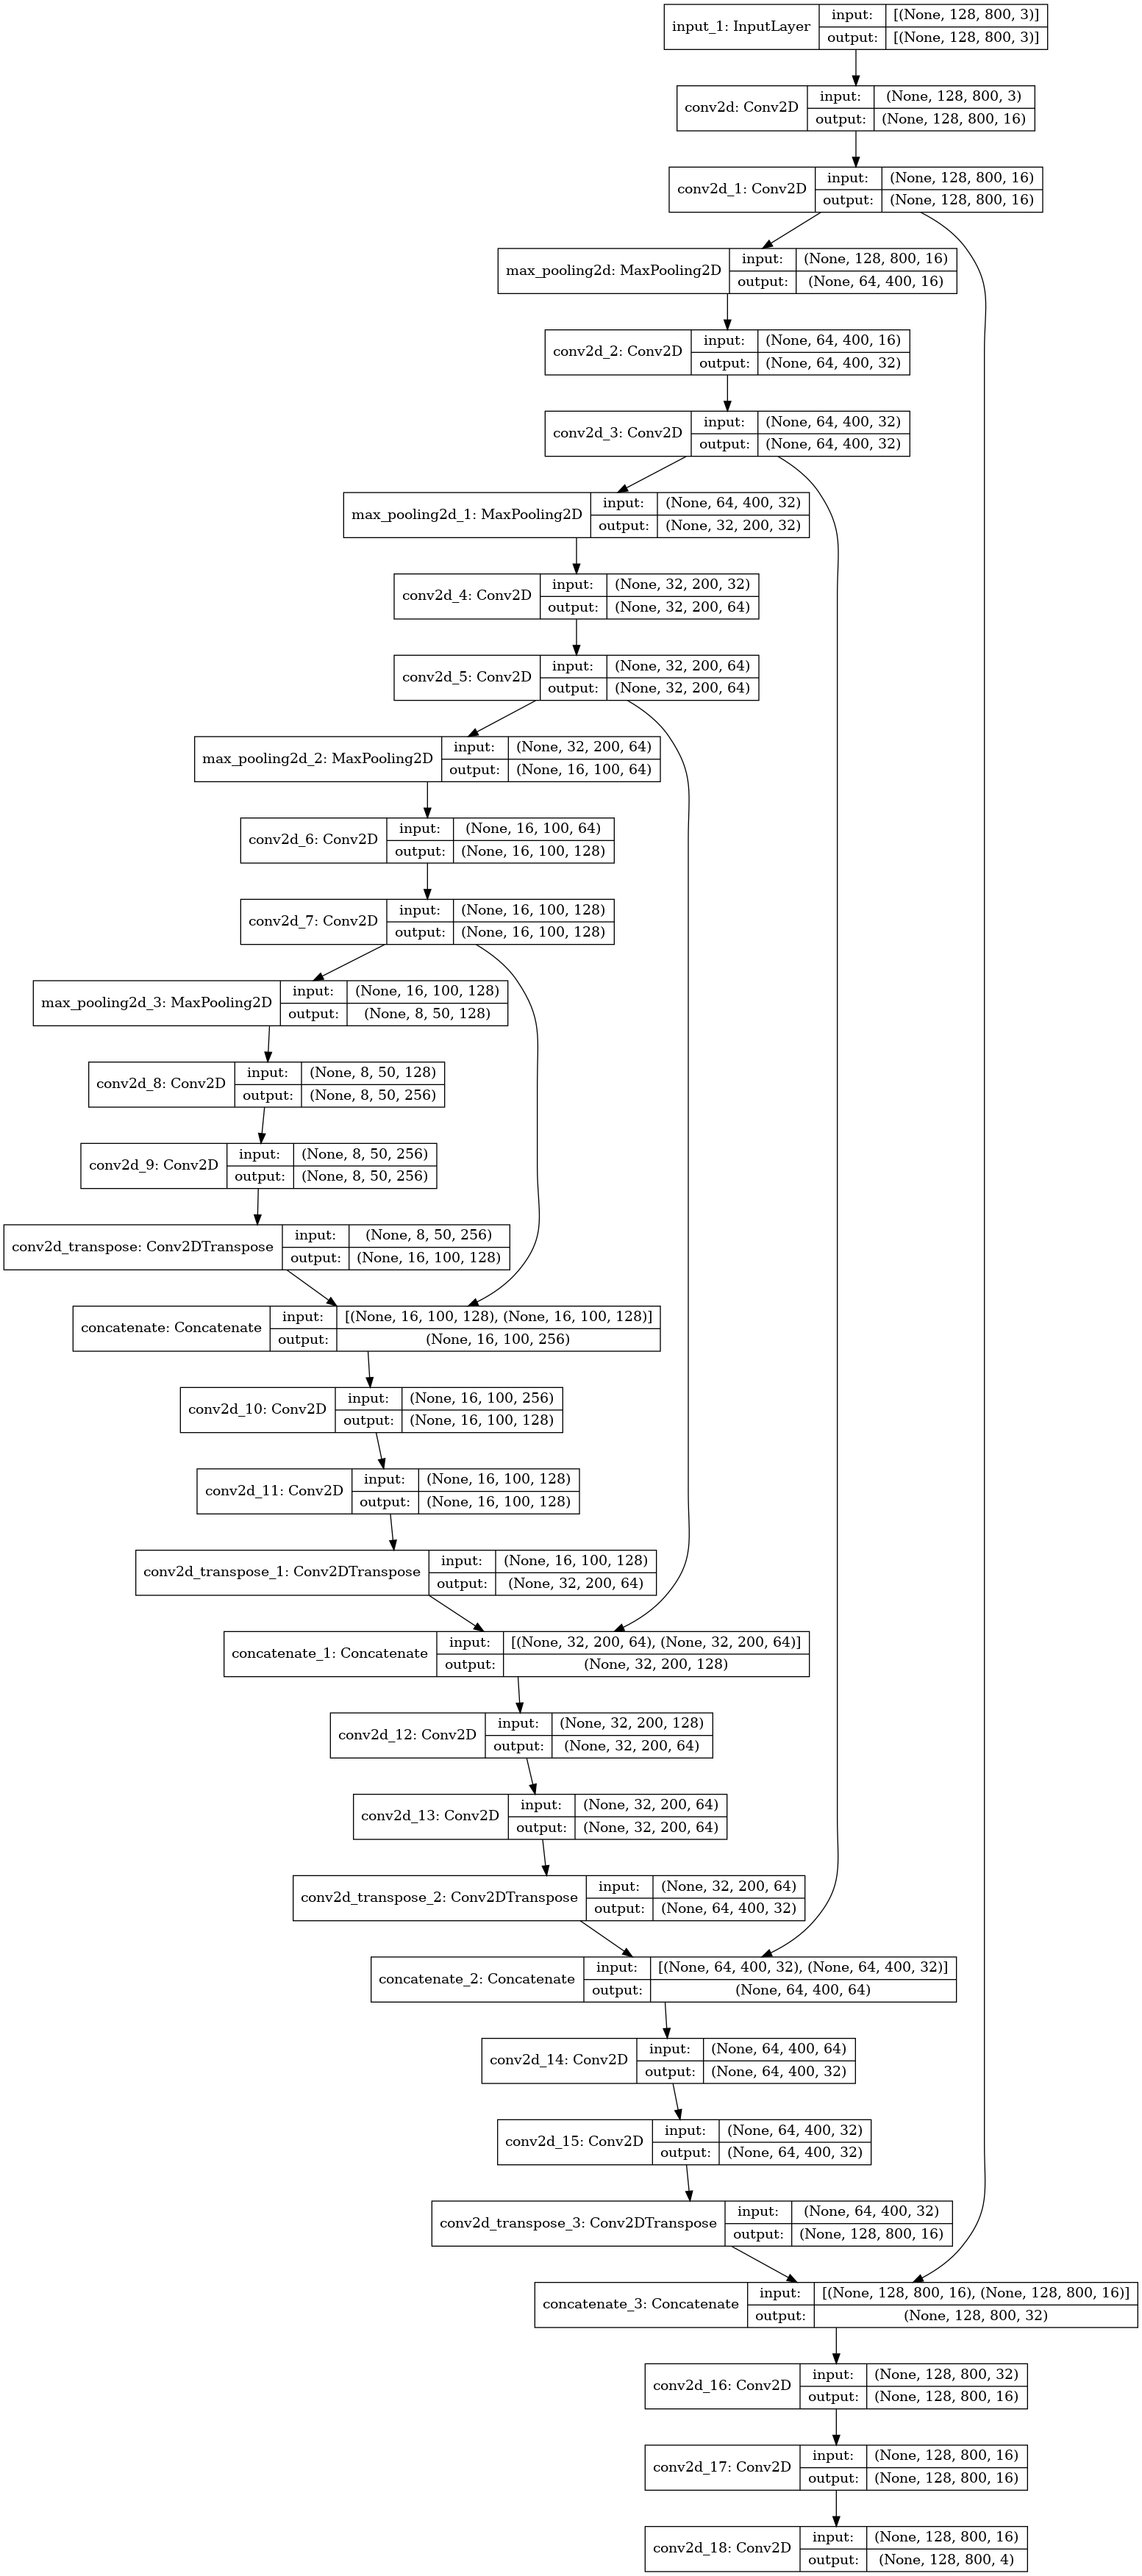

In [15]:
tf.keras.backend.clear_session()
model = get_model((128, 800, 3), 16, 4)
tf.keras.utils.plot_model(model, show_shapes=True)

In [16]:
train_idx = int(0.8*len(train2))
train_loader = DataLoader(train2.iloc[:train_idx], shuffle=True)
valid_loader = DataLoader(train2.iloc[train_idx:])

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint('defect_segmentation.hdf5',
                                                   monitor='val_dice_coef',
                                                   mode='max',
                                                   save_best_only=True,
                                                   save_weights_only=True)
earlystopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                    monitor='val_dice_coef',
                                                    mode='max')

history = model.fit_generator(train_loader,
                              validation_data=valid_loader,
                              epochs=50,
                              callbacks=[checkpoint_cb, earlystopping_cb])

2022-11-26 18:45:42.422228: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/50


2022-11-26 18:45:46.049364: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


629/629 [==============================] - 381s 577ms/step - loss: 0.0656 - dice_coef: 0.0339 - val_loss: 0.0338 - val_dice_coef: 0.0728
Epoch 2/50
629/629 [==============================] - 252s 400ms/step - loss: 0.0296 - dice_coef: 0.1433 - val_loss: 0.0250 - val_dice_coef: 0.2358
Epoch 3/50
629/629 [==============================] - 248s 394ms/step - loss: 0.0247 - dice_coef: 0.2524 - val_loss: 0.0234 - val_dice_coef: 0.3293
Epoch 4/50
629/629 [==============================] - 250s 397ms/step - loss: 0.0235 - dice_coef: 0.2827 - val_loss: 0.0237 - val_dice_coef: 0.2343
Epoch 5/50
629/629 [==============================] - 248s 394ms/step - loss: 0.0221 - dice_coef: 0.3077 - val_loss: 0.0230 - val_dice_coef: 0.2274
Epoch 6/50
629/629 [==============================] - 253s 402ms/step - loss: 0.0213 - dice_coef: 0.3264 - val_loss: 0.0199 - val_dice_coef: 0.3522
Epoch 7/50
413/629 [==================>...........] - ETA: 1:09 - loss: 0.0207 - dice_coef: 0.3293

KeyboardInterrupt: 